In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import xgboost
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-16-2020.csv')

In [3]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-05-17 02:32:32,34.223334,-82.461707,34,0,0,34,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-05-17 02:32:32,30.295065,-92.414197,192,11,0,181,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-05-17 02:32:32,37.767072,-75.632346,668,9,0,659,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-05-17 02:32:32,43.452658,-116.241552,773,22,0,751,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-05-17 02:32:32,41.330756,-94.471059,4,0,0,4,"Adair, Iowa, US"


In [4]:
latest_data['Country_Region'] == "Singapore"

0       False
1       False
2       False
3       False
4       False
        ...  
3299    False
3300    False
3301    False
3302    False
3303    False
Name: Country_Region, Length: 3304, dtype: bool

In [5]:
latest_data[latest_data['Country_Region'] == "Singapore"]

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
3270,NaN,NaN,NaN,Singapore,2020-05-17 02:32:32,1.2833,103.8333,27356,22,8342,18992,Singapore


In [6]:
latest_data.iloc[3270]

FIPS                              NaN
Admin2                            NaN
Province_State                    NaN
Country_Region              Singapore
Last_Update       2020-05-17 02:32:32
Lat                            1.2833
Long_                         103.833
Confirmed                       27356
Deaths                             22
Recovered                        8342
Active                          18992
Combined_Key                Singapore
Name: 3270, dtype: object

In [7]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,842,850,856,868,872,876,880,898,916,933
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,752,752,754,755,755,758,760,761,761,761
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,36,43,43,45,45,45,45,48,48,48


In [8]:
cols = confirmed_df.keys()

In [9]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [10]:
dates = confirmed.keys()

In [11]:
dates

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '5/7/20', '5/8/20', '5/9/20', '5/10/20', '5/11/20', '5/12/20',
       '5/13/20', '5/14/20', '5/15/20', '5/16/20'],
      dtype='object', length=116)

In [12]:
singapore_cases = []
singapore_deaths = []  
singapore_recoveries = [] 

for i in dates:
    
    # confirmed cases
    singapore_cases.append(confirmed_df[confirmed_df['Country/Region']=='Singapore'][i].sum())
    
    # deaths
    singapore_deaths.append(deaths_df[deaths_df['Country/Region']=='Singapore'][i].sum())
    
    # recoveries
    singapore_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Singapore'][i].sum())

In [13]:
singapore_recoveries

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 9,
 15,
 15,
 17,
 18,
 18,
 24,
 29,
 34,
 34,
 37,
 37,
 51,
 51,
 53,
 62,
 62,
 62,
 72,
 72,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 96,
 96,
 97,
 105,
 105,
 109,
 114,
 114,
 114,
 124,
 140,
 144,
 144,
 156,
 160,
 172,
 183,
 198,
 212,
 228,
 240,
 245,
 266,
 282,
 297,
 320,
 344,
 377,
 406,
 460,
 492,
 528,
 560,
 586,
 611,
 652,
 683,
 708,
 740,
 768,
 801,
 839,
 896,
 924,
 956,
 1002,
 1060,
 1095,
 1128,
 1188,
 1244,
 1268,
 1347,
 1408,
 1457,
 1519,
 1634,
 1712,
 2040,
 2296,
 2721,
 3225,
 3851,
 4809,
 5973,
 7248,
 8342]

Get daily increase in confirmed cases, deaths and recoveries

In [14]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d

# confirmed cases
singapore_daily_increase = daily_increase(singapore_cases)

# deaths
singapore_daily_death = daily_increase(singapore_deaths)

# recoveries
singapore_daily_recovery = daily_increase(singapore_recoveries)

In [15]:
singapore_daily_recovery

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 7,
 6,
 0,
 2,
 1,
 0,
 6,
 5,
 5,
 0,
 3,
 0,
 14,
 0,
 2,
 9,
 0,
 0,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 18,
 0,
 1,
 8,
 0,
 4,
 5,
 0,
 0,
 10,
 16,
 4,
 0,
 12,
 4,
 12,
 11,
 15,
 14,
 16,
 12,
 5,
 21,
 16,
 15,
 23,
 24,
 33,
 29,
 54,
 32,
 36,
 32,
 26,
 25,
 41,
 31,
 25,
 32,
 28,
 33,
 38,
 57,
 28,
 32,
 46,
 58,
 35,
 33,
 60,
 56,
 24,
 79,
 61,
 49,
 62,
 115,
 78,
 328,
 256,
 425,
 504,
 626,
 958,
 1164,
 1275,
 1094]

In [16]:
lastthirtydates = dates[len(dates)-30:-1]

In [17]:
lastthirtydates

Index(['4/17/20', '4/18/20', '4/19/20', '4/20/20', '4/21/20', '4/22/20',
       '4/23/20', '4/24/20', '4/25/20', '4/26/20', '4/27/20', '4/28/20',
       '4/29/20', '4/30/20', '5/1/20', '5/2/20', '5/3/20', '5/4/20', '5/5/20',
       '5/6/20', '5/7/20', '5/8/20', '5/9/20', '5/10/20', '5/11/20', '5/12/20',
       '5/13/20', '5/14/20', '5/15/20'],
      dtype='object')

In [18]:
# confirmed cases in the last thirty days
singapore_cases = singapore_cases[len(dates)-30:-1]
singapore_daily_increase = singapore_daily_increase[len(dates)-30:-1]

# deaths in the last thirty days
singapore_deaths = singapore_deaths[len(dates)-30:-1]
singapore_daily_death = singapore_daily_death[len(dates)-30:-1]

# recoveries in the last thirty days
singapore_recoveries = singapore_recoveries[len(dates)-30:-1]
singapore_daily_recovery = singapore_daily_recovery[len(dates)-30:-1]

In [19]:
singapore_cases

[5050,
 5992,
 6588,
 8014,
 9125,
 10141,
 11178,
 12075,
 12693,
 13624,
 14423,
 14951,
 15641,
 16169,
 17101,
 17548,
 18205,
 18778,
 19410,
 20198,
 20939,
 21707,
 22460,
 23336,
 23822,
 24671,
 25346,
 26098,
 26891]

In [20]:
singapore_daily_recovery

[25,
 32,
 28,
 33,
 38,
 57,
 28,
 32,
 46,
 58,
 35,
 33,
 60,
 56,
 24,
 79,
 61,
 49,
 62,
 115,
 78,
 328,
 256,
 425,
 504,
 626,
 958,
 1164,
 1275]

In [21]:
# Dates till date of 'latest_data' dataset 
Current_dates = np.array([i for i in range(len(lastthirtydates))]).reshape(-1, 1)

In [22]:
Current_dates

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28]])

Convert integer into datetime for better visualization

In [23]:
start = '4/17/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
Current_dates_datetime = []
for i in range(len(Current_dates)):
    Current_dates_datetime.append((start_date + datetime.timedelta(days=i)).strftime('%d %b'))

In [24]:
# Reshape array with 1 row
Current_dates_datetime = np.array([i for i in Current_dates_datetime]).reshape(1, -1)[0]

In [34]:
def country_plot(x, y1, y2, y3, y4, country):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y1)
    plt.title('{}: Confirmed Cases'.format(country), size=20)
    plt.xlabel('Dates', size=20)
    plt.ylabel('Number of Cases', size=20)
    plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/8))),size=12)
    plt.yticks(size=15)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y2)
    plt.title('{}: Daily New Confirmed Cases'.format(country), size=20)
    plt.xlabel('Dates', size=20)
    plt.ylabel('Number of Cases', size=20)
    plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/8))),size=12)
    plt.yticks(size=15)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y3)
    plt.title('{}: Deaths'.format(country), size=20)
    plt.xlabel('Dates', size=20)
    plt.ylabel('Number of Cases', size=20)
    plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/8))),size=12)
    plt.yticks(size=15)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y4)
    plt.title('{}: Daily Recovered Cases'.format(country), size=20)
    plt.xlabel('Dates', size=20)
    plt.ylabel('Number of Cases', size=20)
    plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/8))),size=12)
    plt.yticks(size=15)
    plt.show()

Singapore Visualization

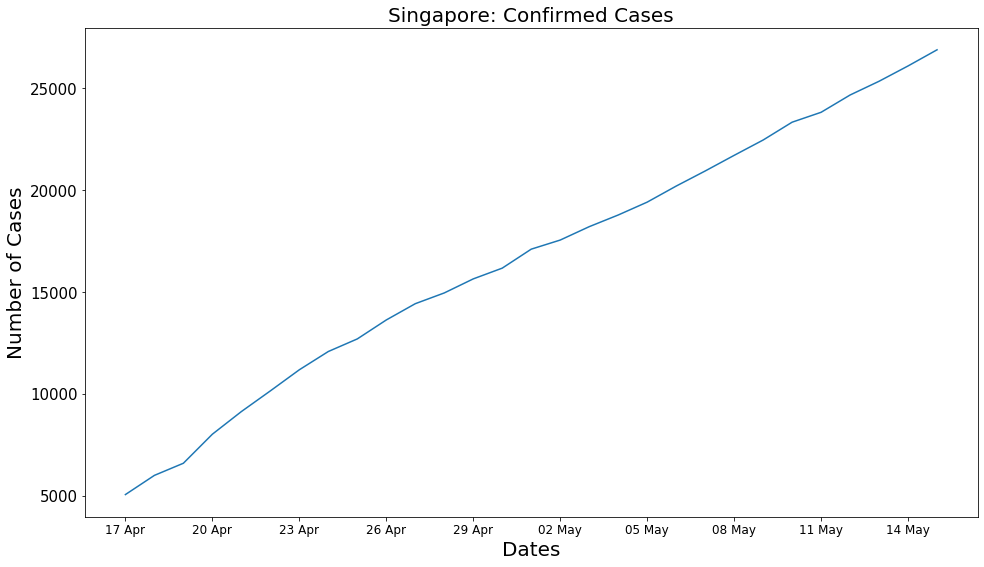

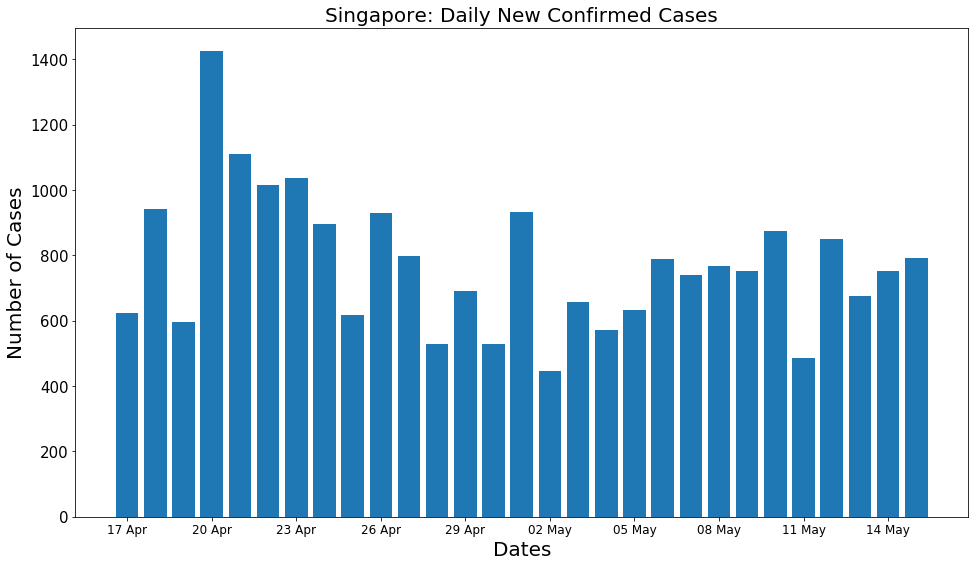

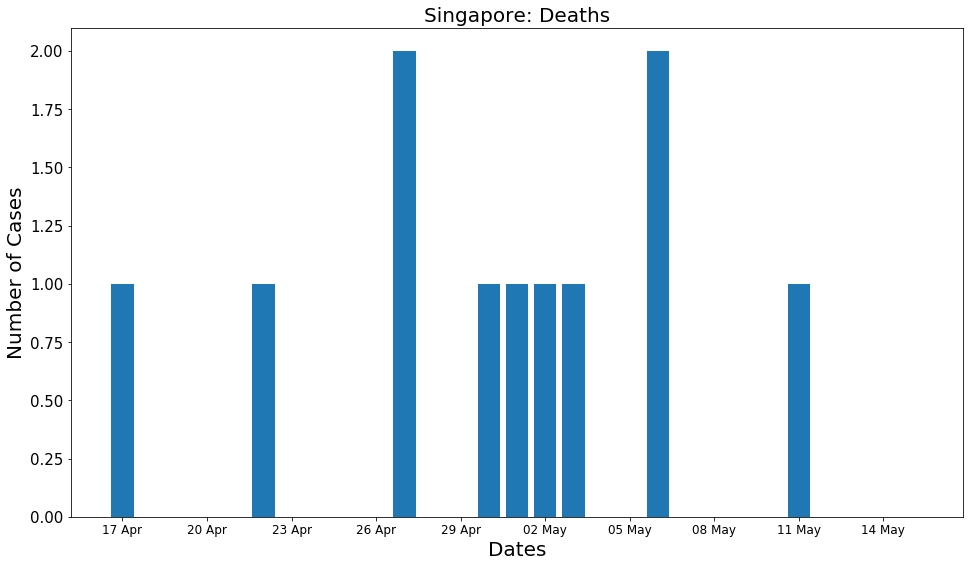

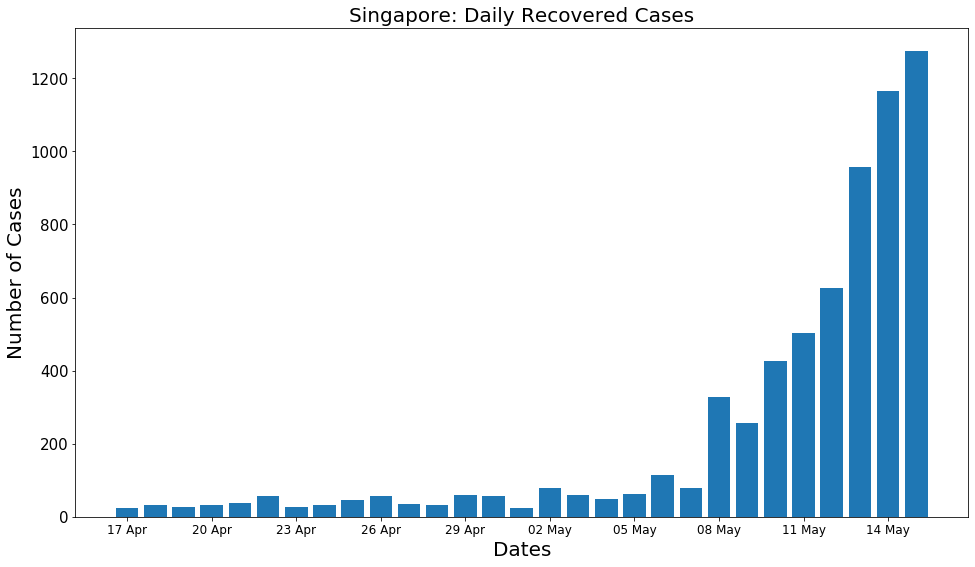

In [35]:
country_plot(Current_dates_datetime, singapore_cases, singapore_daily_increase, singapore_daily_death, singapore_daily_recovery, 'Singapore')